# Case Study: Architecture Fusion for Pet Breed Classification

This notebook applies Architecture Fusion to the Oxford-IIIT Pet dataset. We merge the features of a deep model (ResNet50) and a lightweight model (MobileNetV2) to improve classification performance.

### Core Concepts:
- Transfer Learning: Using pretrained ImageNet weights.
- Feature Concatenation: Merging two distinct feature spaces.
- Data-Driven Visualization: Tracking metrics and inspecting predictions.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


## 1. Data-Driven Exploration
We load the Oxford-IIIT Pet dataset. It is small enough to run quickly but complex enough to benefit from fusion.

Classes: 37 | Training: 2944 | Val: 736


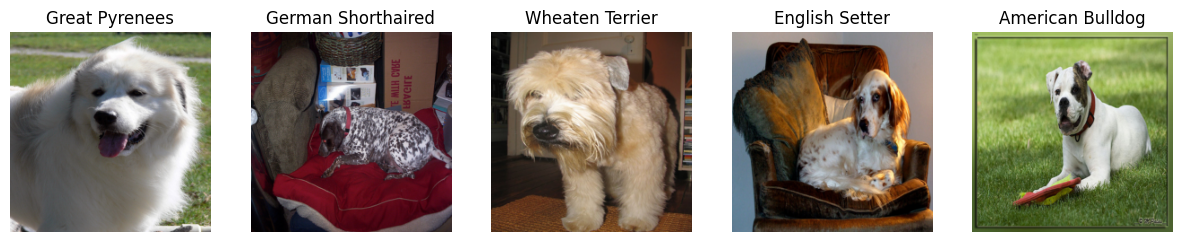

In [2]:
# Define image preprocessing and augmentation pipeline
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),            # Resize images to match model input size
    transforms.RandomHorizontalFlip(),         # Randomly flip images for data augmentation
    transforms.ToTensor(),                     # Convert PIL image to PyTorch tensor
    transforms.Normalize(                     # Normalize using ImageNet statistics
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

# Load the Oxford-IIIT Pet dataset with transforms applied
full_dataset = datasets.OxfordIIITPet(
    root='./data',
    split='trainval',
    download=True,
    transform=data_transforms
)

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(
    full_dataset, [train_size, val_size]
)

# Create DataLoaders for batching and shuffling data
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# Get class names and print dataset statistics
class_names = full_dataset.classes
print(f"Classes: {len(class_names)} | Training: {len(train_data)} | Val: {len(val_data)}")

# Function to display an image tensor after unnormalizing
def imshow(inp, title=None):
    # Convert tensor from (C, H, W) to (H, W, C)
    inp = inp.numpy().transpose((1, 2, 0))
    
    # Unnormalize the image
    inp = np.clip(
        np.array([0.229, 0.224, 0.225]) * inp +
        np.array([0.485, 0.456, 0.406]),
        0, 1
    )
    
    # Display the image
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a batch of training images and labels
inputs, labels = next(iter(train_loader))

# Visualize a few sample images from the training set
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    imshow(inputs[i], title=class_names[labels[i]])
plt.show()


## 2. Architecture Fusion
We concatenate the outputs of ResNet50 and MobileNetV2.

In [ ]:
class FusionNet(nn.Module):
    def __init__(self, num_classes):
        super(FusionNet, self).__init__()

        # -------- Backbone A: ResNet50 --------
        # Load pretrained ResNet50
        res = models.resnet50(pretrained=True)
        # Remove the final fully connected layer, keep feature extractor
        self.backbone_a = nn.Sequential(*list(res.children())[:-1])

        # -------- Backbone B: MobileNetV2 --------
        # Load pretrained MobileNetV2
        mob = models.mobilenet_v2(pretrained=True)
        # Use only the convolutional feature extractor
        self.backbone_b = mob.features
        # Pool feature maps to 1x1 spatial size
        self.pool_b = nn.AdaptiveAvgPool2d(1)

        # -------- Freeze backbone parameters --------
        # Prevent updating pretrained backbone weights during training
        for p in self.backbone_a.parameters():
            p.requires_grad = False
        for p in self.backbone_b.parameters():
            p.requires_grad = False

        # -------- Fusion classifier --------
        # Concatenate ResNet (2048) and MobileNet (1280) features
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 1280, 512),  # Feature fusion layer
            nn.ReLU(),                   # Non-linearity
            nn.Dropout(0.3),             # Regularization
            nn.Linear(512, num_classes)  # Final classification layer
        )

    def forward(self, x):
        # Extract features from ResNet backbone
        f1 = torch.flatten(self.backbone_a(x), 1)

        # Extract features from MobileNet backbone and pool them
        f2 = torch.flatten(self.pool_b(self.backbone_b(x)), 1)

        # Concatenate features from both backbones
        fused = torch.cat((f1, f2), dim=1)

        # Pass fused features through the classifier
        return self.classifier(fused)

# Initialize model and move it to the selected device (CPU/GPU)
model = FusionNet(len(class_names)).to(device)

# Optimize only the classifier parameters (backbones are frozen)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Cross-entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

/home/mihkuno/projects/improcv/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mihkuno/projects/improcv/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/mihkuno/projects/improcv/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You 

## 3. Training & Performance Tracking
We run a short training cycle and plot the results.

In [4]:
from tqdm import tqdm

epochs = 5
stats = {'loss': [], 'acc': []}

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    # tqdm progress bar over batches
    progress_bar = tqdm(
        train_loader,
        desc=f"Epoch [{epoch+1}/{epochs}]",
        leave=False
    )

    for imgs, lbls in progress_bar:
        imgs, lbls = imgs.to(device), lbls.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, lbls)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        total += lbls.size(0)
        correct += (preds == lbls).sum().item()

        # Update tqdm display
        progress_bar.set_postfix(
            loss=loss.item(),
            acc=f"{100 * correct / total:.2f}%"
        )

    avg_loss = total_loss / len(train_loader)
    avg_acc = 100 * correct / total

    stats['loss'].append(avg_loss)
    stats['acc'].append(avg_acc)

    print(f"Epoch {epoch+1}: Loss {avg_loss:.4f} | Acc {avg_acc:.2f}%")


Epoch 1: Loss 1.4096 | Acc 61.65%


Epoch 2: Loss 0.4833 | Acc 84.17%


Epoch 3: Loss 0.3627 | Acc 87.91%


Epoch 4: Loss 0.3004 | Acc 89.74%


Epoch 5: Loss 0.2445 | Acc 91.92%


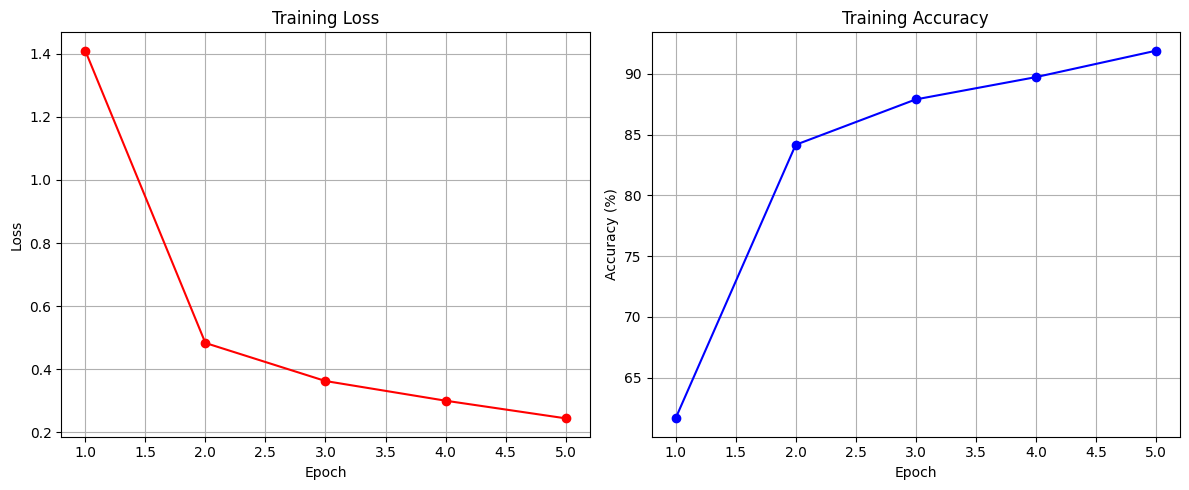

In [6]:
# Plot Loss
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), stats['loss'], marker='o', color='red')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), stats['acc'], marker='o', color='blue')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. Visual Inference (Testing)
We visualize the model's predictions on the validation set.

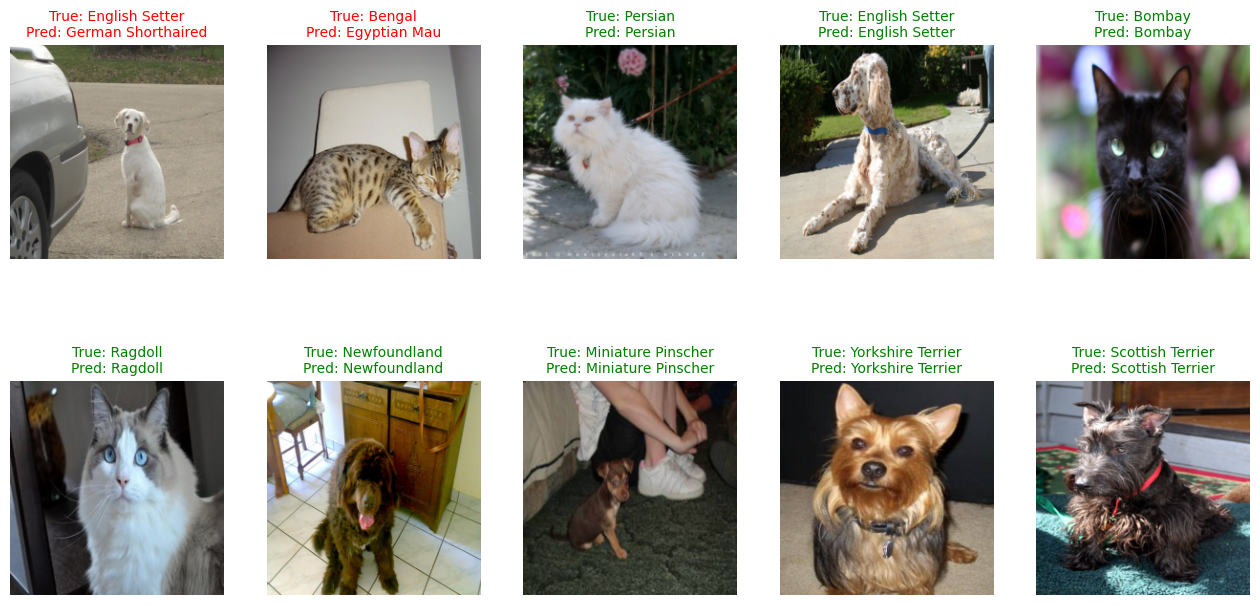

In [5]:
# Set model to evaluation mode (disables dropout, batch norm updates)
model.eval()

# Get a batch of validation images and labels
images, labels = next(iter(val_loader))

# Move data to the selected device (CPU/GPU)
images, labels = images.to(device), labels.to(device)

# Disable gradient computation for inference
with torch.no_grad():
    # Forward pass
    outputs = model(images)
    # Get predicted class indices
    _, preds = torch.max(outputs, 1)

# Create a figure to visualize predictions
plt.figure(figsize=(16, 8))

# Display first 10 validation images with predictions
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Convert tensor to NumPy array and change to (H, W, C)
    img = images[i].cpu().numpy().transpose((1, 2, 0))

    # Unnormalize image (reverse ImageNet normalization)
    img = np.clip(
        np.array([0.229, 0.224, 0.225]) * img +
        np.array([0.485, 0.456, 0.406]),
        0, 1
    )

    # Show image
    plt.imshow(img)

    # Check if prediction is correct
    is_correct = preds[i] == labels[i]

    # Set title color based on correctness
    title_color = 'green' if is_correct else 'red'

    # Display true label and predicted label
    plt.title(
        f"True: {class_names[labels[i]]}\n"
        f"Pred: {class_names[preds[i]]}",
        color=title_color,
        fontsize=10
    )

    plt.axis('off')

plt.show()
